# 22 - Debiasing with Propensity Score

Previously, we saw how to go from a biased dataset to one where the treatment looked as good as randomly assigned. We used orthogonalization for that. That techique was based on predicting the treatment and the outcome and then replacing both with their predictions' residuals. 

$
t^* = t - M_t(X)
$

$
y^* = y - M_y(X)
$

That alone is a powerfull techique. It works both when the treatment is continuous or binary. Now, we will take a look at another techique which is based on the propensity score. Since the propensity score is best defined for when the treatment is binary or categorical, this debiasing technique also works only for categorical treatments. Still, in some situations, it can be more reliable than orthogonalization and it is very much worth learning. 

But first, we need to change context a little bit. We where talkig about icecream prices, which is a continuous treatment. Now, we will look into marketing emails, a binary treatment. And just as a side note, it is totaly fair play to discretize your continuous treatment into buckets so it looks categorial (for example, you can take price, which is continous, and discretize it in bins of R$ 2.00 like [2.00, 4.00, 6.00, 8.00]). 

The situation goes like this. You work at a financial company (I'm not very creative with my examples, sorry) that supplies, not surprisingly, financial products such as life insurance, savings account, investment account and so on. Te company is coming up with a new financial consulting service and want to market it to its customers. To do so, the marketing team try out three different emails: `em1`, `em2` and `em3`. 

Because the marketing team is very well educated in statistics and experimental design, they don't simply send the email to everyone and see what happend. Instead, they design an experiment where each customer has a probability of recieving the email. This probability is based on their business intuition to who will be more responsive to the email. For example, `em1` is targeted to a mass market audience, that don't invest much and that don't have a high income. These people will have higher probability of recieving `em1`. Finally, after having defined that probability, we randomize the assignment so that customers recieve the email according to their assigned probabilities.

![img](./data/img/debias-ps/ps-experiment.png)

By the way, this is the best way I know of that uses business expertise to target an audience while still allowing you to make valid inference about how effective the marketing strategy is. So, the marketing team not only assigned the email acording to this probability function, but they actually stored each customers' probability, wich will be very handy latter on. 

Here is what the data from this experiment looks like. We have data on four customers attributes: `age`, `income`, how much they have on life `insurance` and how much they have `invested`. These are the attributes wich the marketing team used to assing the probability of recieving each email. Those probabilities are stores in columns `em1_ps`, `em2_ps` and `em3_ps`. Then, we have information on whether the customer actually recieved the email on columns `em1`, `em2` and `em3`. These are our treatment variables. Finally, we have the outome, `converted`, which is if the customer contracted the financial advisory service.

In [23]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [24]:
email = pd.read_csv("./data/invest_email.csv")
email.head()

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted
0,44.1,4214.66,14036.41,7988.66,0.118507,0.045174,0.921281,0,0,1,1
1,39.8,1151.27,66622.15,1000.74,0.431123,0.005659,0.000000,1,0,0,0
2,49.0,8047.26,14119.53,29480.22,0.062137,0.166706,0.840049,0,0,1,0
3,39.7,10558.37,14798.26,36373.09,0.047372,0.205684,0.000000,0,0,0,0
4,35.3,802.15,780.84,1643.16,0.616450,0.009292,0.000000,1,0,0,0


As we can see, there are customers with very low probability of recieving `em1`. This is the case of customer 2, which has a probability of only 0.062. Also notice that this customer did not recieved `em1`. This is not surprising, given that he had a very low probability of recieving this email. 

In [3]:
confounders = ["age", "income", "insurance", "invested"]

In [4]:
email[confounders + ["em1"]].corr()["em1"]

age         -0.058796
income      -0.305610
insurance   -0.023948
invested    -0.242374
em1          1.000000
Name: em1, dtype: float64

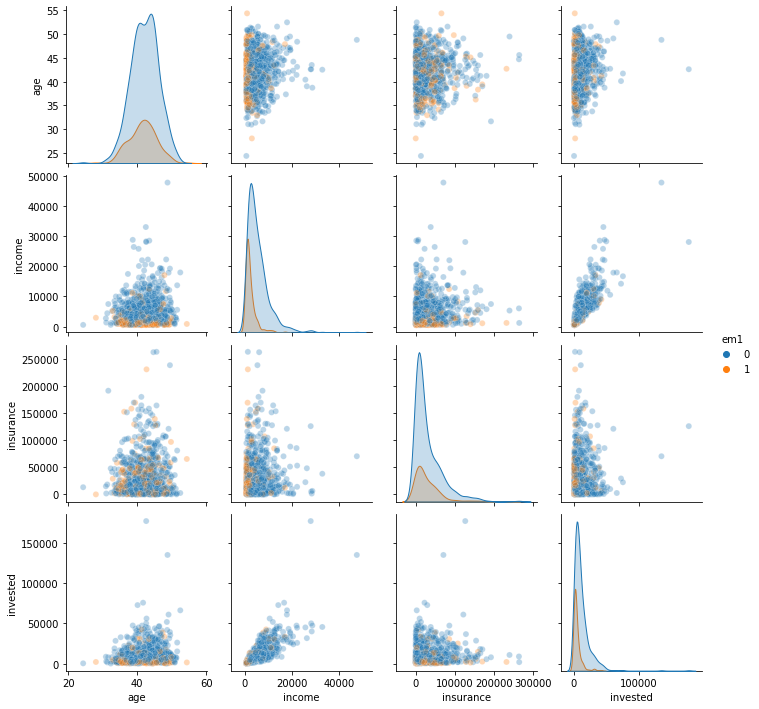

In [5]:
sns.pairplot(email.sample(1000)[confounders + ["em1"]], hue="em1", plot_kws=dict(alpha=0.3))

## Stored Propensity Score

In [6]:
em1_rnd = email.assign(
    em1_w = np.where(email["em1"].astype(bool), 1/email["em1_ps"], 1/(1-email["em1_ps"]))
).sample(10000, replace=True, weights="em1_w")

In [7]:
np.random.seed(5)
em1_rnd.sample(5)

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted,em1_w
2525,36.6,667.47,25639.24,680.44,0.739000,0.003848,0.000000,0,0,0,0,3.831410
4842,27.8,2757.19,18615.49,6549.26,0.180924,0.037035,0.000000,1,0,0,0,5.527195
2558,40.8,10170.50,31281.24,30949.33,0.049177,0.175013,0.795047,1,0,1,1,20.334565
4904,36.5,3693.67,713.41,9246.49,0.135177,0.052287,0.000000,0,0,0,1,1.156306
3310,36.7,13284.82,6851.71,44580.12,0.037658,0.252093,0.000000,1,0,0,0,26.555118


In [8]:
em1_rnd[confounders + ["em1"]].corr()["em1"]

age         -0.019783
income      -0.023134
insurance   -0.029715
invested    -0.008700
em1          1.000000
Name: em1, dtype: float64

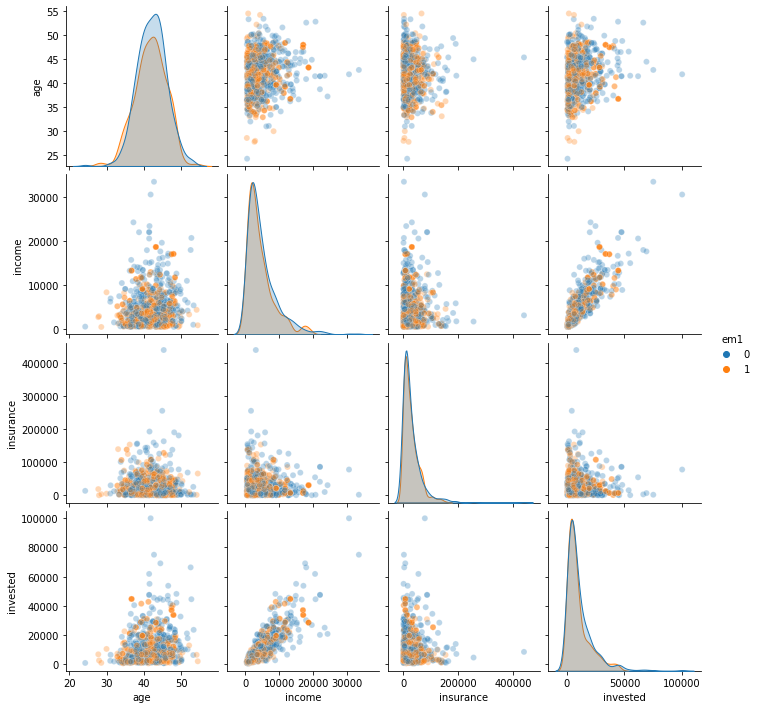

In [9]:
sns.pairplot(em1_rnd.sample(1000)[confounders + ["em1"]], hue="em1", plot_kws=dict(alpha=0.3))

## Estimated Propensity Score

In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

t = "em1"

folds = 5

np.random.seed(123)
m_t = CalibratedClassifierCV(RandomForestClassifier(n_estimators=100, min_samples_leaf=10), cv=3)
ps_score_m1 = cross_val_predict(m_t, email[confounders], email[t], cv=folds, method="predict_proba")[:, 1]

In [11]:
email.assign(ps_score_m1_est = ps_score_m1).head()

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted,ps_score_m1_est
0,44.1,4214.66,14036.41,7988.66,0.118507,0.045174,0.921281,0,0,1,1,0.115926
1,39.8,1151.27,66622.15,1000.74,0.431123,0.005659,0.000000,1,0,0,0,0.307491
2,49.0,8047.26,14119.53,29480.22,0.062137,0.166706,0.840049,0,0,1,0,0.091406
3,39.7,10558.37,14798.26,36373.09,0.047372,0.205684,0.000000,0,0,0,0,0.089521
4,35.3,802.15,780.84,1643.16,0.616450,0.009292,0.000000,1,0,0,0,0.766401


In [12]:
em1_rnd_est = (email
               .assign(em1_w = np.where(email["em1"].astype(bool), 1/ps_score_m1, 1/(1-ps_score_m1)))
               .sample(10000, replace=True, weights="em1_w"))

In [13]:
em1_rnd_est[confounders + ["em1"]].corr()["em1"]

age         -0.027726
income      -0.184693
insurance   -0.004997
invested    -0.144870
em1          1.000000
Name: em1, dtype: float64

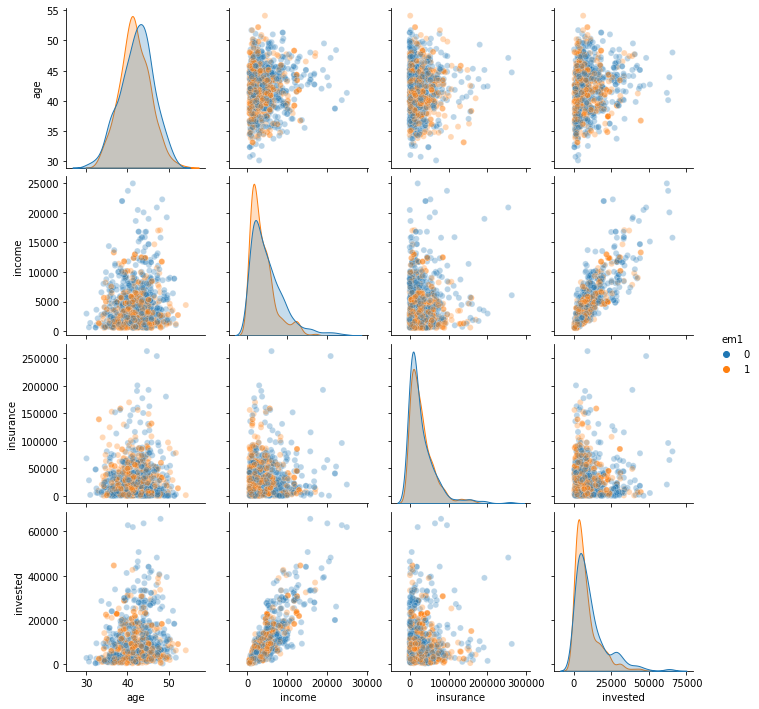

In [14]:
sns.pairplot(em1_rnd_est.sample(1000)[confounders + ["em1"]], hue="em1", plot_kws=dict(alpha=0.3))

## Positivity

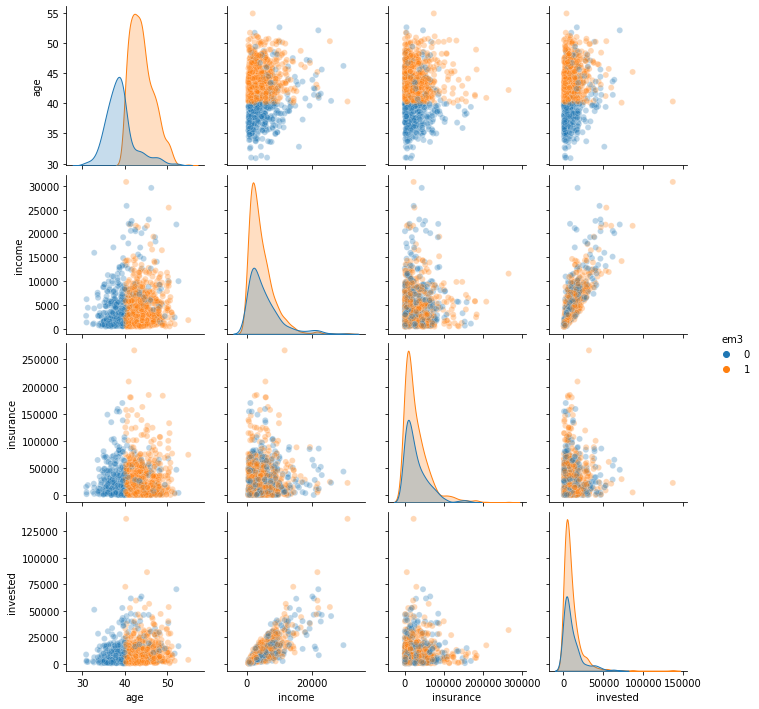

In [15]:
sns.pairplot(email.sample(1000)[confounders + ["em3"]], hue="em3", plot_kws=dict(alpha=0.3))

In [16]:
em3_weight = (email
              .assign(em3_w = np.where(email["em3"].astype(bool), 1/email["em3_ps"], 1/(1-email["em3_ps"])))
              .sample(10000, replace=True, weights="em3_w"))

In [17]:
em3_weight.head()

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted,em3_w
2194,39.5,590.00,27405.07,1959.88,0.834417,0.011083,0.000000,1,0,0,0,1.000000
2643,38.9,4254.81,27269.95,8001.53,0.117391,0.045247,0.000000,0,0,0,0,1.000000
4071,42.0,2075.58,6592.33,2067.43,0.240053,0.011691,0.966619,0,0,0,0,29.957427
1729,41.9,603.23,35092.77,2373.29,0.816415,0.013421,0.997826,0,0,0,0,459.941996
1939,42.7,9850.35,8153.25,6380.74,0.050774,0.036082,0.801833,0,0,0,1,5.046242


In [18]:
em3_weight[confounders + ["em3"]].corr()["em3"]

age          0.260283
income       0.064672
insurance   -0.009313
invested     0.084771
em3          1.000000
Name: em3, dtype: float64

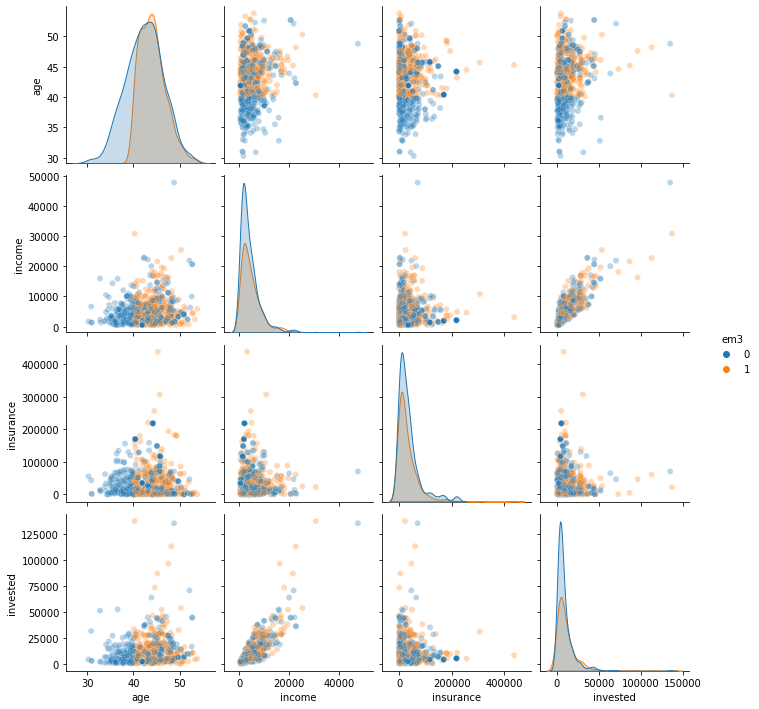

In [19]:
sns.pairplot(em3_weight.sample(1000)[confounders + ["em3"]], hue="em3", plot_kws=dict(alpha=0.3))

In [20]:
em3_weight.query("age>40")[confounders + ["em3"]].corr()["em3"]

age         -0.024562
income       0.048953
insurance   -0.015196
invested     0.056718
em3          1.000000
Name: em3, dtype: float64

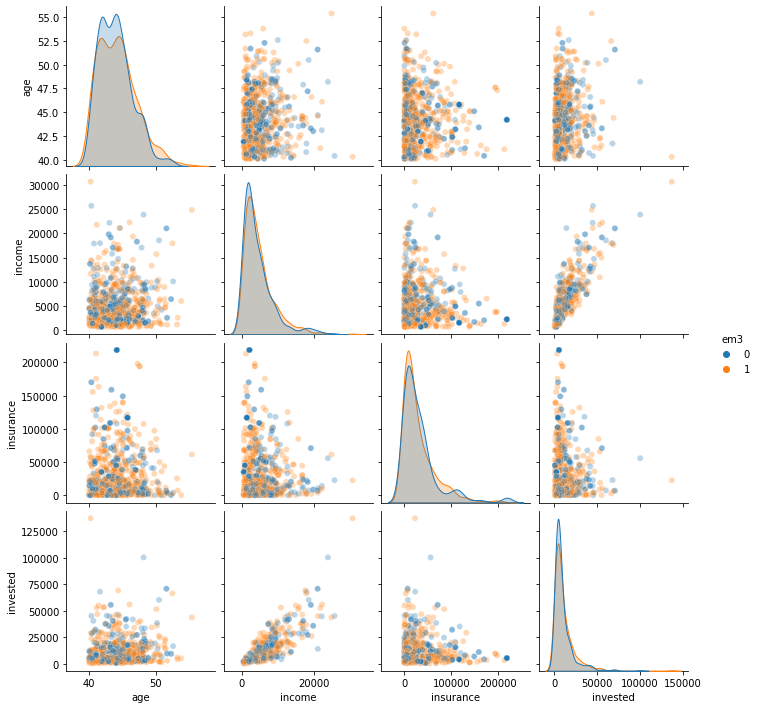

In [21]:
sns.pairplot(em3_weight.query("age>40").sample(1000)[confounders + ["em3"]], hue="em3", plot_kws=dict(alpha=0.3))